MUPETALKS
=====

- Preciso pegar o dataset do MUPE e fazer um recorte nele seguindo algumas regras.
- As regras são essencialmente ditadas pelo paper de referência: [DailyTalk](https://arxiv.org/abs/2207.01063).

### Regras de recorte:
1. Pegar somente pessoas falantes de SP capital;
2. Como o início das entrevistas no MUPE contêm dados sensíveis, foi discutido para começar um pouco pra frente pra garantir anonimidade. Talvez esta anonomidade tenha que ser refinada manualmente;
3. 

### Datasets
- MUPE-ASR: [CORAA-MUPE-ASR | HuggingFace](https://huggingface.co/datasets/nilc-nlp/CORAA-MUPE-ASR): $\approx 41.8 \text{ GB}$
    - train: 277k
    - test: 10k
    - validation: 31k
- Metadata: [Google Sheets | Metadata](https://docs.google.com/spreadsheets/d/1_gg2bL8TbIbqarlR3sfthMzGTiANvJis/edit?gid=1202708851#gid=1202708851)

### References

- To create an audio corpus: [HuggingFace](https://huggingface.co/docs/datasets/audio_dataset)


## Considerations

- `birth_state == Null`

    Where the `birth_country != 'Brasil'` the states are `Null`

    ```
    birth_country
    Brasil       272
    Portugal       4
    Chile          4
    Alemanha       3
    Argentina      2
    Nigéria        1
    Japão          1
    Mónaco         1
    Itália         1
    Name: count, dtype: int64
    ```



# Imports

In [1]:
import re
import os
import difflib
from enum import Enum
from pathlib import Path
from typing import List, Tuple, cast, Literal

import rich
import datasets
import numpy as np
import pandas as pd
from google import genai 
# from dotenv import load_dotenv
from google.genai import types
from datasets import Audio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from pydantic import BaseModel, Field
from matplotlib.colors import ListedColormap
from IPython.display import Audio as ipyAudio

NOTEBOOKS_PATH = Path.cwd()
DATASETS_PATH = NOTEBOOKS_PATH / "datasets"
MUPE_GIT_PATH = DATASETS_PATH / "coling-mupe-asr"
assert all([DATASETS_PATH.exists(), MUPE_GIT_PATH.exists()])


custom_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00",
    "#ffff33", "#a65628", "#f781bf", "#999999", "#66c2a5",
    "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
    "#e5c494", "#b3b3b3", "#1b9e77", "#d95f02", "#7570b3",
    "#e7298a", "#66a61e", "#e6ab02", "#a6761d", "#666666"
]

mupe_cmap = ListedColormap(custom_colors, name="MupeExcelColorMap")

matplotlib.colormaps.register(name="MupeExcelColorMap", cmap=mupe_cmap, force=True)

# Audio(filename="./file_example_WAV_1MG.wav")
# os.environ["VERTEX_AI_API_KEY"], os.environ["GEMINI_API_KEY"]

/home/antonio-moreira/Documents/my-masters-degree/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Opening train dataset

In [2]:
mupe_train = pd.read_csv(MUPE_GIT_PATH / "train.csv")
mupe_train.head(2)

,audio_id,audio_name,file_path,speaker_type,speaker_code,speaker_gender,audio_quality,start_time,end_time,duration,normalized_text,original_text
0,859,pc_ma_hv064,train/pc_ma_hv064/pc_ma_hv064_0_6.69_8.37.wav,P/2,MA108,F,high,6.693,8.374,1.681,ponto de cultura museu aberto,"Ponto de Cultura, Museu Aberto."
1,859,pc_ma_hv064,train/pc_ma_hv064/pc_ma_hv064_5_26.53_27.87.wav,P/1,ADC052,F,high,26.528,27.869,1.341,bom dia professor,"Bom dia, professor."


In [5]:
# Getting some statistics from `mupe_train`

# rows
num_rows = mupe_train.shape[0]
# number of uniques `audio_name` and `audio_id`
num_unique_audio_names = mupe_train['audio_name'].nunique()
num_unique_audio_ids = mupe_train['audio_id'].nunique()

print(f"Number of rows: {num_rows}"
      f"\nNumber of unique audio names: {num_unique_audio_names}"
      f"\nNumber of unique audio IDs: {num_unique_audio_ids}"
)

Number of rows: 276881
Number of unique audio names: 250
Number of unique audio IDs: 250


## A sample

In [5]:
' '.join(mupe_train[mupe_train['audio_id'] == 859]['normalized_text'].astype(str))

'ponto de cultura museu aberto bom dia professor estamos aqui no museu da cultura hoje é dia vinte e seis de setembro de dois mil e sete professor para começar eu gostaria que o senhor dissesse o seu nome completo data e local de nascimento nasci no dia trinta e um de maio de mil novecentos e cinquenta e dois numa cidade do interior joanópolis depois por volta de dez anos então vim para são paulo e estou até hoje em são paulo qual o nome do seu pai e da sua mãe eh quantos irmãos nós somos em sete irmãos sendo quatro homens e três mulheres entre o meu irmão mais velho e eu que sou caçula da dos sete nós temos uma diferença de vinte e cinco anos todos ainda todos ainda vivos o que o que o senhor sabe sobre a origem da sua família bom uma origem humilde não chegaram a ter essa oportunidade do estudo ainda na na época em que nasci o estudo ainda era uma coisa ou para quem morava na cidade ou para gente rica né quer dizer um colírio melhor a pessoa que morava num sítio como é num sítio numa

# Processing Metadata

In [3]:
mupe_metadata = pd.read_csv("/home/antonio-moreira/Documents/my-masters-degree/notebooks/TESTE_DEV_TRAIN_mupe_metadados_289.xlsx - df_full6.csv", sep=',')
mupe_metadata.head()

,split,braz_id,mupe_id,mupe_code,interviewee_name,current_audio_name,mupe_link,youtube_link,recording_date,interviewer1,...,gender,birthday,religion,education,birth_city,occupation,profession,birth_state,birth_country,interviewee_bio
0,test,901.0,15085.0,PC_MA_HV169,Patricia Santos Souza,PC_MA_HV169_Patricia Santos Souza,https://museudapessoa.org/historia-detalhe/?id...,https://www.youtube.com/watch?v=non3ULc83pA,2008-11-04,Ricardo Pedroni,...,Feminino,1981-08-25,Catolicismo,Nível Técnico,Simão Dias,NaN,Balconista e faxineira,Sergipe,Brasil,"Patricia Santos Souza nasceu em 1981, em Sergi..."
1,dev,31.0,119.0,PC_MA_HV003,Simone Mattos de Alcântara Pinto,PC_MA_HV003_Simone Mattos de Alcântara Pinto,https://museudapessoa.org/historia-detalhe/?id...,https://www.youtube.com/watch?v=EAcPf_JhR_4,2007-05-15,Maria Lenir Justo,...,Feminino,1958-10-03,NaN,Superior Completo,São Paulo,Consultora de educação e cultura,Pedagoga,São Paulo,Brasil,Simone Mattos de Alcântara Pinto nasceu em São...
2,train,859.0,6715.0,PC_MA_HV064,Durval Bueno,PC_MA_HV064_Durval Bueno,https://museudapessoa.org/historia-detalhe/?id...,https://www.youtube.com/watch?v=mpnW-41UnYk,2007-09-26,Aparecida da Cruz,...,Masculino,1952-03-31,NaN,NaN,Joanópolis,NaN,Professor de História,São Paulo,Brasil,"Durval Bueno nasceu em Joanópolis, cidade do i..."
3,train,423.0,6718.0,PC_MA_HV024,Wagner Pinheiro,PC_MA_HV024_Wagner Pinheiro,https://museudapessoa.org/historia-detalhe/?id...,https://www.youtube.com/watch?v=pYkYxbdMtYg,2007-07-05,Emílio Cordeiro,...,Masculino,1960-05-04,NaN,NaN,São Paulo,NaN,Professor de História,São Paulo,Brasil,O professor Wagner ingressou na PUC no ano de ...
4,train,505.0,6842.0,PC_MA_HV235,Roberta de Oliveira,PC_MA_HV235_Roberta de Oliveira,https://museudapessoa.org/historia-detalhe/?id...,https://www.youtube.com/watch?v=BPreRmzA03E,2010-02-04,Marta Dellelis,...,Feminino,1972-08-24,NaN,NaN,Campinas,NaN,Educadora e articuladora comunitária,São Paulo,Brasil,"Filha de pais separados, Roberta logo cedo con..."


In [4]:
def preprocess_metadata_dataset(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[df['birth_country'] == 'Brasil']
    df = df[['split', 'braz_id', 'mupe_code', 'interviewee_name',
       'youtube_link', 'interviewer1', 'interviewer2', 'interviewer3', 'title',
       'gender', 'birth_state', 'interviewee_bio']]
    df = df.rename(columns={'braz_id': 'audio_id'})
    print(f"Number of rows with NA in 'audio_id': {df['audio_id'].isna().sum()}")
    df = df.dropna(subset=['audio_id'])
    df['audio_id'] = df['audio_id'].astype(int)
    return df

In [5]:
mupe_metadata = preprocess_metadata_dataset(mupe_metadata)
mupe_metadata.head()

Number of rows with NA in 'audio_id': 0


,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio
0,test,901,PC_MA_HV169,Patricia Santos Souza,https://www.youtube.com/watch?v=non3ULc83pA,Ricardo Pedroni,Mariana Casellato,NaN,Paixão e movimento na grande São Paulo,Feminino,Sergipe,"Patricia Santos Souza nasceu em 1981, em Sergi..."
1,dev,31,PC_MA_HV003,Simone Mattos de Alcântara Pinto,https://www.youtube.com/watch?v=EAcPf_JhR_4,Maria Lenir Justo,Laura Olivieri,NaN,Dança entre memórias,Feminino,São Paulo,Simone Mattos de Alcântara Pinto nasceu em São...
2,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i..."
3,train,423,PC_MA_HV024,Wagner Pinheiro,https://www.youtube.com/watch?v=pYkYxbdMtYg,Emílio Cordeiro,Patrícia Fortunato,NaN,Professor de ideias,Masculino,São Paulo,O professor Wagner ingressou na PUC no ano de ...
4,train,505,PC_MA_HV235,Roberta de Oliveira,https://www.youtube.com/watch?v=BPreRmzA03E,Marta Dellelis,Isabela de Arruda,NaN,Pérola rara no viver e no cantar,Feminino,São Paulo,"Filha de pais separados, Roberta logo cedo con..."


In [21]:
mupe_metadata[mupe_metadata['birth_state'].isna()]

,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio


In [10]:
mupe_metadata_sp = mupe_metadata[mupe_metadata['birth_state'].str.contains('Paulo')].reset_index(drop=True)
print(mupe_metadata_sp.shape)
mupe_metadata_sp.head()

(167, 12)


,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio
0,dev,31,PC_MA_HV003,Simone Mattos de Alcântara Pinto,https://www.youtube.com/watch?v=EAcPf_JhR_4,Maria Lenir Justo,Laura Olivieri,NaN,Dança entre memórias,Feminino,São Paulo,Simone Mattos de Alcântara Pinto nasceu em São...
1,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i..."
2,train,423,PC_MA_HV024,Wagner Pinheiro,https://www.youtube.com/watch?v=pYkYxbdMtYg,Emílio Cordeiro,Patrícia Fortunato,NaN,Professor de ideias,Masculino,São Paulo,O professor Wagner ingressou na PUC no ano de ...
3,train,505,PC_MA_HV235,Roberta de Oliveira,https://www.youtube.com/watch?v=BPreRmzA03E,Marta Dellelis,Isabela de Arruda,NaN,Pérola rara no viver e no cantar,Feminino,São Paulo,"Filha de pais separados, Roberta logo cedo con..."
4,train,501,PC_MA_HV238,Vânia Bure,https://www.youtube.com/watch?v=IUl-xIuwKWk,Nadia Lopes de Camargo,Fernanda Prado,NaN,Defensora dos direitos da população em Mauá,Feminino,São Paulo,Vânia nasceu em 12 de janeiro de 1967 em Lucél...


In [ ]:
input = """
audio_id                    interviewer1
    31               Maria Lenir Justo
    859               Aparecida da Cruz
    423                 Emílio Cordeiro
    505                  Marta Dellelis
    501          Nadia Lopes de Camargo
    493                   Thiago Majolo
    484            Eduardo Barros Pinto
    508          Nadia Lopes de Camargo
"""

prompt = (
    "Classifique cada nome brasileiro listado a seguir como Masculino, Feminino ou Unknown.\n"
    "O input provém de um conjunto dados armazenado num pandas.DataFrame, onde cada nome está associado a um ID de áudio único.\n"
    "Responda somente com JSON no formato: "
    '[{"audio_id": "ID", "name": "Nome", "gender": "Masculino|Feminino|Unknown"}, ...].\n\n'
    f"Nomes:\n{input}"
)

print(prompt)

Classifique cada nome brasileiro listado a seguir como Masculino, Feminino ou Unknown.
O input provém de um conjunto dados armazenado num pandas.DataFrame, onde cada nome está associado a um ID de áudio único.
Responda somente com JSON no formato: [{"audio_id": "ID", "name": "Nome", "gender": "Masculino|Feminino|Unknown"}, ...].

Nomes:

audio_id                    interviewer1
    31               Maria Lenir Justo
    859               Aparecida da Cruz
    423                 Emílio Cordeiro
    505                  Marta Dellelis
    501          Nadia Lopes de Camargo
    493                   Thiago Majolo
    484            Eduardo Barros Pinto
    508          Nadia Lopes de Camargo



In [23]:
class GenderItem(BaseModel):
    audio_id: int = Field(..., description="ID do áudio")
    name: str = Field(..., description="Nome completo")
    gender: Literal["Masculino", "Feminino", "Unknown"]


class GenderClassification(BaseModel):
    results: List[GenderItem]

    
def get_gender_map(names: str) -> GenderClassification | None:
    prompt = (
        "Classifique cada nome brasileiro listado a seguir como Masculino, Feminino ou Unknown.\n"
        "O input provém de um conjunto dados armazenado num pandas.DataFrame, onde cada nome está associado a um ID de áudio único.\n"
        "Responda somente com JSON no formato: "
        '[{"audio_id": "ID", "name": "Nome", "gender": "Masculino|Feminino|Unknown"}, ...].\n\n'
        f"Nomes:\n{names}"
    )

    client = genai.Client(
        vertexai=True,
        api_key=os.environ.get("VERTEX_AI_API_KEY"),
    )

    config = types.GenerateContentConfig(
        temperature=0.1,
        top_p=0.95,
        response_mime_type="application/json",
        response_schema=GenderClassification,
    )

    try:
        response = client.models.generate_content(
            model="gemini-3-pro-preview",
            contents=[
                types.Content(role="user", parts=[types.Part.from_text(text=prompt)])
            ],
            config=config,
        )

        assert isinstance((response_parsed := response.parsed), GenderClassification)

        return response_parsed
    except Exception as e:
        print(f"Error during Vertex AI execution: {e}")
        return None

def rank_name_similarity(target: str, candidates: List[str]) -> List[Tuple[str, float]]:
    target_norm = target.strip().casefold()
    scores = []
    for name in candidates:
        cand_norm = name.strip().casefold()
        ratio = difflib.SequenceMatcher(None, target_norm, cand_norm).ratio()
        scores.append((name, ratio))
    scores.sort(key=lambda item: item[1], reverse=True)
    best_candidate = scores[0]
    return best_candidate[0]

def infer_gender_from_map(name: str, gender_map: dict):
    key_name = rank_name_similarity(name, list(gender_map.keys()))
    return gender_map.get(key_name, 'Unknown')


# name_gender_map = get_gender_map(mupe_metadata['interviewee_name'].tolist())

# mupe_metadata['interviewee_gender'] = mupe_metadata['interviewee_name'].map(
#     lambda person: infer_gender_from_map(person, name_gender_map)
# )

In [24]:
name_gender_map = get_gender_map(mupe_metadata_sp[['audio_id', 'interviewer1']].to_string(index=False))

In [29]:
pd.DataFrame(
    [[gender_item.audio_id, gender_item.gender] for gender_item in name_gender_map.results],
    columns=['audio_id', 'gender']
)

,audio_id,gender
0,31,Feminino
1,859,Feminino
2,423,Masculino
3,505,Feminino
4,501,Feminino
...,...,...
162,844,Feminino
163,398,Masculino
164,401,Masculino
165,397,Feminino


In [17]:
mupe_metadata_sp['interviewer2'] = mupe_metadata_sp['interviewer2'].fillna('Unknown')
name_gender_map = get_gender_map(mupe_metadata_sp['interviewer2'].tolist())

mupe_metadata_sp['interviewer2_gender'] = mupe_metadata_sp['interviewer2'].map(
    lambda person: infer_gender_from_map(person, name_gender_map)
)

In [19]:
mupe_metadata_sp_gender_slice = mupe_metadata_sp[mupe_metadata_sp['gender'] != mupe_metadata_sp['interviewer1_gender']]
mupe_metadata_sp_gender_slice.to_csv("/home/antonio-moreira/Documents/my-masters-degree/notebooks/datasets/CORAA-MUPE/mupe_metadata_sp_gender_slice.csv", index=False)
mupe_metadata_sp_gender_slice.head()

,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio,interviewer1_gender,interviewer2_gender
1,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i...",Feminino,Feminino
6,train,484,PC_MA_HV241,Maria Jose da Silva Carvalho,https://www.youtube.com/watch?v=XGB9q1a3EsY,Eduardo Barros Pinto,Isabela de Arruda,NaN,Não há cidadania sem luta,Feminino,São Paulo,A infância de Maria José foi marcada pelas bri...,Masculino,Feminino
9,train,461,PC_MA_HV249,Horacio Calligaris Galvanese,https://youtu.be/7BDzInfYf0o,Marta Dellelis,Isabela de Arruda,NaN,Pelo exercício da cidadania,Masculino,São Paulo,"Horácio é paulistano, nascido em 1954. Na juve...",Feminino,Feminino
13,train,481,PC_MA_HV258,Waldemar Antonio G. Saroka (Tuka),https://youtu.be/U9n68mE-Ees,Marina Galvanese,Isabela de Arruda,NaN,O Tuca da Mooca,Masculino,São Paulo,"Os avós maternos de Tuca, apelido de infância ...",Feminino,Feminino
14,train,824,PC_MA_HV188,Adriano da Silva,https://www.youtube.com/watch?v=BhHPoCTc81g,Gisele Vitor da Rocha,Mariana Casellato,NaN,Colecionador de histórias,Masculino,São Paulo,Adriano da Silva nasceu no dia três de julho d...,Feminino,Feminino


In [ ]:
mupe_metadata_sp['interviewer3'] = mupe_metadata_sp['interviewer3'].fillna('Unknown')
name_gender_map = get_gender_map(mupe_metadata_sp['interviewer3'].tolist())

mupe_metadata_sp['interviewer3_gender'] = mupe_metadata_sp['interviewer3'].map(
    lambda person: infer_gender_from_map(person, name_gender_map)
)

# Merge Train & Metadata datasets

In [3]:
mupe_metadata_sp = pd.read_csv(NOTEBOOKS_PATH / "mupe_metadata_sp_gender_slice.csv")
mupe_metadata_sp.drop(columns=['interviewer2_gender'], inplace=True)

# mupe_selected_ids = mupe_metadata_sp['audio_id'].tolist()

# Total duration: 106.63130944444445
# print(f"Total duration: {mupe_train[mupe_train['audio_id'].isin(mupe_metadata_sp['audio_id'])]['duration'].sum()/3600}")

mupe_metadata_sp.head(4)

,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio,interviewer1_gender
0,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i...",Feminino
1,train,484,PC_MA_HV241,Maria Jose da Silva Carvalho,https://www.youtube.com/watch?v=XGB9q1a3EsY,Eduardo Barros Pinto,Isabela de Arruda,NaN,Não há cidadania sem luta,Feminino,São Paulo,A infância de Maria José foi marcada pelas bri...,Masculino
2,train,461,PC_MA_HV249,Horacio Calligaris Galvanese,https://youtu.be/7BDzInfYf0o,Marta Dellelis,Isabela de Arruda,NaN,Pelo exercício da cidadania,Masculino,São Paulo,"Horácio é paulistano, nascido em 1954. Na juve...",Feminino
3,train,481,PC_MA_HV258,Waldemar Antonio G. Saroka (Tuka),https://youtu.be/U9n68mE-Ees,Marina Galvanese,Isabela de Arruda,NaN,O Tuca da Mooca,Masculino,São Paulo,"Os avós maternos de Tuca, apelido de infância ...",Feminino


It is important to document this behavior:

```python
>>> all(mupe_metadata_sp['mupe_code'].str.startswith('PC_MA_HV'))
True
```

# Sample case

- MA108: Aparecida da Cruz
- ADC052: Marta Alves
- MA_HV064: Durval Bueno

---

- Agregar entrevistadores diferentes num mesmo codigo (SOMENTE SE AS REGRAS DO **DAILYTALK** NAO FOREM VIOLADAS)
- Separar os dialogos por assunto abordado


In [5]:
def get_interviewer_code(mupe_sample: pd.DataFrame) -> tuple[str, list[str]]:
    speaker_counts = mupe_sample["speaker_code"].value_counts()

    if len(speaker_counts) > 2:
        interviewer_codes = speaker_counts.index[1:]
        join_code:str = "_".join(interviewer_codes)
    else:
        join_code:str = speaker_counts.index[-1]
        interviewer_codes = [join_code]

    return join_code, list(interviewer_codes)


def aggregate_sample_dialogues(mupe_df: pd.DataFrame, audio_id: int) -> tuple[pd.DataFrame, list[int], str]:
    """
    Aggregate contiguous utterances for a given audio_id and detect missing file counters.

    Returns
    -------
    tuple[pd.DataFrame, list[int], str]
        - Aggregated blocks with merged interviewer turns.
        - Sorted list of missing file_id counters.
        - The joined interviewer speaker_code.
    """
    sample = mupe_df.loc[mupe_df["audio_id"] == audio_id].sort_values("start_time").copy()

    if sample.empty:
        raise ValueError(f"No rows found for audio_id={audio_id}")

    join_code, interviewer_codes = get_interviewer_code(sample)
    
    if len(interviewer_codes) > 1:
        sample.loc[sample["speaker_code"].isin(interviewer_codes), "speaker_code"] = join_code

    block_id = (sample["speaker_code"] != sample["speaker_code"].shift()).cumsum()
    
    file_path_extract = sample["file_path"].str.extract(
        r"pc_ma_(?P<mupe_code>hv\d{3})_(?P<file_id>\d+)_")
    
    #TODO log the mupe_code value
    assert all(file_path_extract['mupe_code'] == file_path_extract['mupe_code'].iloc[0]), \
        "Multiple mupe_code values found in the sample."
    
    file_id_series = file_path_extract["file_id"].astype(int)

    df_agg = (
        sample.assign(block_id=block_id, file_id=file_id_series)
        .groupby("block_id")
        .agg(
            file_path=("file_path", list),
            file_id=("file_id", list),
            speaker_code=("speaker_code", "first"),
            start_time=("start_time", "min"),
            end_time=("end_time", "max"),
            duration=("duration", "sum"),
            original_text=("original_text", " ".join),
        )
        .reset_index(drop=True)
    )

    if file_id_series.empty:
        return df_agg, [], join_code

    file_ids = file_id_series.to_numpy(dtype=int)
    expected = set(range(file_ids.min(), file_ids.max() + 1))
    missing_ids = sorted(expected.difference(file_ids))
    return df_agg, missing_ids, join_code

In [34]:
# Valid audios ids: 859, 484, 461
mupe_train_sample, missing_ids_sample, itvw_code = aggregate_sample_dialogues(mupe_train, audio_id=507)
# display(missing_ids_sample)
mupe_train_sample.head(3)

,file_path,file_id,speaker_code,start_time,end_time,duration,original_text
0,[train/pc_ma_hv229/pc_ma_hv229_0_20.628_22.869...,[0],MD006,20.628,22.869,2.241,o local e a data de seu nascimento?
1,[train/pc_ma_hv229/pc_ma_hv229_1_22.869_24.47....,[1],MA_HV229,22.869,24.470,1.601,Claro.
2,[train/pc_ma_hv229/pc_ma_hv229_5_43.8610000000...,[5],MD006,43.861,46.303,2.442,E o que que eles faziam?


In [6]:
# Id: 844 has 3 codes: ['RMNH003', 'ADSP097', 'KV128'] into 'RMNH003_ADSP097_KV128'
itvw_codes_list = []

for audio_id in mupe_metadata_sp[mupe_metadata_sp["split"] == "train"]["audio_id"]:
    sample = mupe_train[mupe_train["audio_id"] == int(audio_id)].copy()
    join_code, interviewer_codes = get_interviewer_code(sample)
    itvw_codes_list.append([audio_id, join_code, interviewer_codes])

itvw_codes_df = pd.DataFrame(itvw_codes_list, columns=['audio_id', 'interviewer_join_code', 'interviewer_codes'])
# Only the "well behaved" ones
itvw_codes_df = itvw_codes_df[itvw_codes_df["interviewer_codes"].apply(len) == 1]
itvw_codes_df.head(3)

,audio_id,interviewer_join_code,interviewer_codes
1,484,EBP007,[EBP007]
4,824,GVDR016,[GVDR016]
7,468,IDA013,[IDA013]


Altought we have missing ids, they are not in contiguous blocks

```python
{
    "TOPIC" : {"SEGMENT_ID": "SEGMENT_TIMESTAMP"}
}
```

In [7]:
class QuestionMetadata(BaseModel):
    id: int = Field(..., description="O ID numérico da pergunta (ex: 0, 2, 4)")
    timestamp: str = Field(..., description="O timestamp original (ex: 00:06)")

class SubSection(BaseModel):
    subtitle: str = Field(..., description="O subtítulo do roteiro (ex: IDENTIFICAÇÃO)")
    items: List[QuestionMetadata]

class Section(BaseModel):
    title: str = Field(..., description="O título principal do roteiro (ex: INTRODUÇÃO)")
    subsections: List[SubSection]

class InterviewSegmentation(BaseModel):
    segments: List[Section]

In [8]:
def get_questions_df(sample_df: pd.DataFrame, interview_code:str) -> pd.DataFrame:
    questions_df = sample_df[sample_df["speaker_code"] == interview_code][["original_text", "start_time"]].copy()
    assert not questions_df.empty, f"No questions found for interview_code={interview_code}"
    return questions_df

def split_interview_questions(sample_df: pd.DataFrame, interview_code:str) -> tuple[InterviewSegmentation, pd.DataFrame] | tuple[None, None]:
    questions_list = []

    questions_df = get_questions_df(sample_df, interview_code)

    for idx, row in questions_df.iterrows():
        questions_list.append(f"{idx} - {int(row.start_time//60):02d}:{int(row.start_time%60):02d} - {row.original_text}")

    #TODO should move the content locally?
    with open("./roteiro_entrevista.md", "r") as f:
        roteiro_entrevista_md = f.read()

    prompt = f"""
    Você é um especialista em história oral e análise de transcrições. 
    Sua tarefa é segmentar a transcrição de uma entrevista fornecida abaixo de acordo com o Roteiro de Perguntas oficial.

    REGRAS DE PROCESSAMENTO:
    1. Analise o conteúdo semântico de cada linha da transcrição para decidir a qual seção/subseção do roteiro ela pertence.
    2. Se um tema fugir do roteiro (ex: falar de faculdade na seção errada), aloque-o na seção semanticamente mais próxima (ex: faculdade -> Escola/Formação).
    3. **CRUCIAL**: Na saída, NÃO inclua o texto da pergunta. Retorne APENAS o 'id' e o 'timestamp' dentro da estrutura hierárquica correta.
    4. Mantenha a ordem cronológica original das perguntas dentro dos grupos.
    5. Não utilize caracteres de marcação Markdown (ex: #, ##, etc) nos títulos e subtítulos.

    ROTEIRO BASE:
    {roteiro_entrevista_md}

    TRANSCRIÇÃO PARA SEGMENTAR:
    {"\n".join(questions_list)}
    """

    client = genai.Client(
        vertexai=True,
        api_key=os.environ.get("VERTEX_AI_API_KEY"),
    )

    model = "gemini-3-pro-preview"
    
    generate_content_config = types.GenerateContentConfig(
        temperature=0.1,
        top_p=0.95,
        
        response_mime_type="application/json",
        response_schema=InterviewSegmentation,

        safety_settings=[
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_HARASSMENT,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
        ]
    )

    try:
        response = client.models.generate_content(
            model=model,
            contents=[
                types.Content(role="user", parts=[types.Part.from_text(text=prompt)])
            ],
            config=generate_content_config,
        )
        
        assert isinstance((response_parsed := response.parsed), InterviewSegmentation)
        return response_parsed, questions_df
    except Exception as e:
        print(f"Erro na execução do Vertex AI: {e}")
        return None, None

In [ ]:
interview_segmentation_sample, questions_df_sample = split_interview_questions(mupe_train_sample, interview_code=itvw_code)

Some `ids` failed in the first run. I´ve ran again and it works (maybe was a timeout issue).

In [ ]:
# This for runs over all training samples and saves the interview segmentations as JSON files
for audio_id in mupe_metadata_sp[mupe_metadata_sp["split"] == "train"]["audio_id"]:
    mupe_train_sample, missing_ids_sample, itvw_code = aggregate_sample_dialogues(mupe_train, audio_id=int(audio_id))
    interview_segmentation_sample, questions_df = split_interview_questions(mupe_train_sample, itvw_code)
    if interview_segmentation_sample is not None and questions_df is not None:
        segmentation_path = NOTEBOOKS_PATH / "interview_segmentations" / f"interview_segmentation_{audio_id}.json"
        segmentation_path.write_text(interview_segmentation_sample.model_dump_json(indent=2), encoding="utf-8")
        print(f"Segmentation saved for audio_id={audio_id} with interview_code={itvw_code}")
    else:
        print(f"Segmentation failed for audio_id={audio_id} with interview_code={itvw_code}")

In [17]:
itvw_codes_df.head()

,audio_id,interviewer_join_code,interviewer_codes
1,484,EBP007,[EBP007]
4,824,GVDR016,[GVDR016]
7,468,IDA013,[IDA013]
10,794,CL004,[CL004]
16,425,LVP011,[LVP011]


In [9]:
# This for iterates over the saved interview segmentation JSON files and 
#   loads the first that matches an audio_id in itvw_codes_df
file_name_re = re.compile(r"interview_segmentation_(?P<audio_id>\d+)\.json")

for file in Path("interview_segmentations").glob("interview_segmentation_*.json"):
    file_id = int(file_name_re.match(file.name).group("audio_id"))
    mupe_train_sample, missing_ids_sample, itvw_code = aggregate_sample_dialogues(mupe_train, audio_id=file_id)
    if file_id in itvw_codes_df["audio_id"].values:
        print(f"Processing file for audio_id={file_id} with interview_code={itvw_code}")
        interview_segmentation_sample = InterviewSegmentation.model_validate_json(
            file.read_text(encoding="utf-8")
        )
        questions_df_sample = get_questions_df(mupe_train_sample, itvw_code)
        break
    else:
        print(f"Skipping file for audio_id={file_id} not in itvw_codes_df")
        continue

display(mupe_metadata_sp[mupe_metadata_sp["audio_id"] == file_id])
display(mupe_train_sample.head(3))
questions_df_sample.head(3)

Processing file for audio_id=507 with interview_code=MD006


,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio,interviewer1_gender
55,train,507,PC_MA_HV229,Adilson Pereira Lobo,https://www.youtube.com/watch?v=2G-Vf0Nh0RY,Marta Dellelis,Isabela de Arruda,NaN,Adilson Show,Masculino,São Paulo,Adilson Pereira Lobo nasceu em São Paulo no di...,Feminino


,file_path,file_id,speaker_code,start_time,end_time,duration,original_text
0,[train/pc_ma_hv229/pc_ma_hv229_0_20.628_22.869...,[0],MD006,20.628,22.869,2.241,o local e a data de seu nascimento?
1,[train/pc_ma_hv229/pc_ma_hv229_1_22.869_24.47....,[1],MA_HV229,22.869,24.470,1.601,Claro.
2,[train/pc_ma_hv229/pc_ma_hv229_5_43.8610000000...,[5],MD006,43.861,46.303,2.442,E o que que eles faziam?


,original_text,start_time
0,o local e a data de seu nascimento?,20.628
2,E o que que eles faziam?,43.861
4,E quantos anos você tinha quando seu pai morre...,63.588


In [10]:
audio_id = 507
file = Path("interview_segmentations") / f"interview_segmentation_{audio_id}.json"
assert file.exists(), f"File {file} does not exist."
# display(mupe_metadata_sp[mupe_metadata_sp["audio_id"] == audio_id])

mupe_train_sample, missing_ids_sample, itvw_code = aggregate_sample_dialogues(mupe_train, audio_id=audio_id)
interview_segmentation_sample = InterviewSegmentation.model_validate_json(
    file.read_text(encoding="utf-8")
)
questions_df_sample = get_questions_df(mupe_train_sample, itvw_code)
# display(mupe_train_sample.head(3))
questions_df_sample.head(3)


,original_text,start_time
0,o local e a data de seu nascimento?,20.628
2,E o que que eles faziam?,43.861
4,E quantos anos você tinha quando seu pai morre...,63.588


In [10]:
class ClassLabel(str, Enum):
    INTRODUCAO = "INTRODUÇÃO"
    IDENTIFICACAO = "IDENTIFICAÇÃO"
    INFANCIA = "INFÂNCIA"
    FAMILIA = "FAMÍLIA"
    ESCOLA = "ESCOLA"
    JUVENTUDE = "JUVENTUDE"
    DESENVOLVIMENTO = "DESENVOLVIMENTO"
    TRABALHO_COMERCIO = "TRABALHO/ COMÉRCIO"
    FINALIZACAO = "FINALIZAÇÃO"

print(ClassLabel.TRABALHO_COMERCIO.name)
# dir(ClassLabel.INTRODUCAO)

TRABALHO_COMERCIO


In [11]:
def classify_questions(
    questions_parsed: InterviewSegmentation,
    inter_questions: pd.DataFrame,
    level: str | None = None,
) -> pd.DataFrame:
    """
    Attach classification columns to the questions DataFrame.

    Parameters
    ----------
    questions_parsed : InterviewSegmentation
        Parsed segmentation object.
    inter_questions : pd.DataFrame
        DataFrame with questions; its index must correspond to the parsed IDs.
    level : str | None, optional
        If "section", only adds a 'section' column.
        If "subsection", only adds a 'subsection' column.
        If None (default), adds both.

    Returns
    -------
    pd.DataFrame
        Copy of inter_questions with classification columns.
    """
    if level not in {"section", "subsection", None}:
        raise ValueError("level must be 'section', 'subsection', or None")

    id2cls: dict[int, tuple[ClassLabel, ClassLabel, str]] = {}
    for seg in questions_parsed.segments:
        for sub in seg.subsections:
            for item in sub.items:
                try:
                    id2cls[item.id] = (
                        ClassLabel(seg.title),
                        ClassLabel(sub.subtitle),
                        item.timestamp,
                    )
                except ValueError as e:
                    rich.print(f"[yellow] Warning [/yellow]: {e} for item id={item.id}, title='{seg.title}', subtitle='{sub.subtitle}'")
                    id2cls[item.id] = (
                        ClassLabel(seg.title),
                        ClassLabel(seg.title),
                        item.timestamp,
                    )
                except ValueError as e:
                    rich.print(f"[red] Error [/red]: {e} for item id={item.id}, title='{seg.title}', subtitle='{sub.subtitle}'")
                    raise e

    missing = set(inter_questions.index) - set(id2cls.keys())
    if missing:
        raise ValueError(f"Unclassified question ids: {sorted(missing)}")

    df = inter_questions.copy()
    if level in (None, "section"):
        df["section"] = df.index.map(lambda i: id2cls[i][0])
    if level in (None, "subsection"):
        df["subsection"] = df.index.map(lambda i: id2cls[i][1])
    return df
    

assert isinstance(interview_segmentation_sample, InterviewSegmentation) and isinstance(questions_df_sample, pd.DataFrame)

questions_parsed_classified = classify_questions(
    questions_parsed=interview_segmentation_sample,
    inter_questions=questions_df_sample,
    level="subsection"
)

 Warning : 'CONSIDERAÇÕES FINAIS' is not a valid ClassLabel for item id=88, title='FINALIZAÇÃO', 
subtitle='CONSIDERAÇÕES FINAIS'

 Warning : 'CONSIDERAÇÕES FINAIS' is not a valid ClassLabel for item id=90, title='FINALIZAÇÃO', 
subtitle='CONSIDERAÇÕES FINAIS'

 Warning : 'CONSIDERAÇÕES FINAIS' is not a valid ClassLabel for item id=92, title='FINALIZAÇÃO', 
subtitle='CONSIDERAÇÕES FINAIS'

In [14]:
def missing_ids_into_list(ids: List[int]) -> tuple[list[int], int]:
    missing_ids = [i for i in range(ids[0], ids[-1] + 1) if i not in ids]
    return missing_ids, len(missing_ids)

def get_missing_ids(mupe_sample: pd.DataFrame, n_conssecutives_ids: int = 1) -> pd.DataFrame:
    
    missing_ids_result = pd.DataFrame(
        mupe_sample["file_id"].apply(missing_ids_into_list).tolist(),
        columns=["missing_ids", "missing_count"],
    )

    missing_count_mask = missing_ids_result["missing_count"] > 0
    missing_ids_result = missing_ids_result.loc[missing_count_mask]

    consecutives_missing_ids_mask = missing_ids_result.apply(
        lambda row: any(np.diff(row['missing_ids']) == n_conssecutives_ids), axis=1)
    
    return missing_ids_result.loc[consecutives_missing_ids_mask]

# get_missing_ids(mupe_train_sample)

In [12]:
mupe_train_sample_final = mupe_train_sample.merge(
    questions_parsed_classified["subsection"], left_index=True, right_index=True, how="left"
).ffill().copy()
mupe_train_sample_final.head(2)

,file_path,file_id,speaker_code,start_time,end_time,duration,original_text,subsection
0,[train/pc_ma_hv229/pc_ma_hv229_0_20.628_22.869...,[0],MD006,20.628,22.869,2.241,o local e a data de seu nascimento?,ClassLabel.IDENTIFICACAO
1,[train/pc_ma_hv229/pc_ma_hv229_1_22.869_24.47....,[1],MA_HV229,22.869,24.470,1.601,Claro.,ClassLabel.IDENTIFICACAO


In [15]:
def post_process_mupe_sample(mupe_sample: pd.DataFrame) -> pd.DataFrame:
    """Drop all rows whose subsection is ClassLabel.IDENTIFICACAO."""
    mupe_sample = mupe_sample.copy()
    missing_ids = get_missing_ids(mupe_sample)
    mupe_sample = mupe_sample.drop(index=missing_ids.index)
    filtered = mupe_sample.loc[mupe_sample["subsection"] != ClassLabel.IDENTIFICACAO].copy()
    del(missing_ids)
    return filtered

mupe_train_sample_postprocessed = post_process_mupe_sample(mupe_train_sample_final)

In [17]:
mupe_train_sample_postprocessed.loc[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 39]]["subsection"].unique()

array([<ClassLabel.FAMILIA: 'FAMÍLIA'>, <ClassLabel.INFANCIA: 'INFÂNCIA'>],
      dtype=object)

In [16]:
def get_group_mapping(mupe_sample: pd.DataFrame):
    file_id:int = mupe_sample['file_id'].iloc[0][-1]-1
    
    gp_id = 1
    group_map = {}
    group = []
    
    for idx, row in mupe_sample.iterrows():
        file_id_list:list[int] = row['file_id']
        first_id = file_id_list[0]
        last_id = file_id_list[-1]
        if file_id+1 == first_id:
            group.append(idx)
            file_id = last_id
        else:
            file_id = last_id
            if group:
                group_map[gp_id] = group
                gp_id += 1
            group = [idx]

    return group_map

mapping = get_group_mapping(mupe_train_sample_postprocessed)

inverse_map = {idx: gid for gid, idxs in mapping.items() for idx in idxs}

mupe_train_sample_postprocessed["group_id"] = (
    mupe_train_sample_postprocessed.index.map(inverse_map.get).astype("Int8")
)

mupe_train_sample_postprocessed_final = mupe_train_sample_postprocessed.dropna(subset=["group_id"])
mupe_train_sample_postprocessed_final.head(5)


,file_path,file_id,speaker_code,start_time,end_time,duration,original_text,subsection,group_id
2,[train/pc_ma_hv229/pc_ma_hv229_5_43.8610000000...,[5],MD006,43.861,46.303,2.442,E o que que eles faziam?,ClassLabel.FAMILIA,1
3,[train/pc_ma_hv229/pc_ma_hv229_6_46.303_48.224...,"[6, 7]",MA_HV229,46.303,63.588,15.894,"Meu pai era mecânico de máquinas, E minha mãe ...",ClassLabel.FAMILIA,1
4,[train/pc_ma_hv229/pc_ma_hv229_8_63.588_65.911...,"[8, 9, 10, 11]",MD006,63.588,70.034,6.446,E quantos anos você tinha quando seu pai morre...,ClassLabel.FAMILIA,1
5,[train/pc_ma_hv229/pc_ma_hv229_12_70.033999999...,[12],MA_HV229,70.034,72.677,2.643,"Infelizmente, quase nada.",ClassLabel.FAMILIA,1
6,[train/pc_ma_hv229/pc_ma_hv229_13_72.676999999...,[13],MD006,72.677,73.658,0.981,"Mas da sua mãe, sim?",ClassLabel.FAMILIA,1


In [19]:
unique_groups = sorted(mupe_train_sample_postprocessed_final["group_id"].unique())
group_to_color = {g: to_hex(mupe_cmap(i)) for i, g in enumerate(unique_groups)}

def highlight_group(row):
    assert isinstance(row, pd.Series)
    color = group_to_color.get(row["group_id"], "#FFFFFF")
    return [f"background-color: {color}"] * len(row)

excel_path = NOTEBOOKS_PATH / "mupe_train_sample_postprocessed_final.xlsx"
# mupe_train_sample_postprocessed_final.style.apply(highlight_group, axis=1).to_excel(excel_path, index=False)

/tmp/ipykernel_6971/27944157.py:13: UserWarning: Overwriting the cmap 'MupeExcelColorMap' that was already in the registry.
  matplotlib.colormaps.register(name="MupeExcelColorMap", cmap=cmap, force=True)


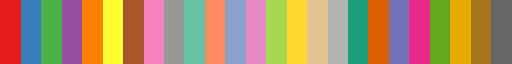

In [ ]:
cmap = plt.get_cmap("MupeExcelColorMap", 25)
cmap

-----

In [ ]:
df = pd.read_csv("datasets/mupe-from-pdf/interview_output.csv")
df = df[df["Identifier"].str.contains('r')]
df

# MUPE

```markdown
# INTRODUÇÃO
## IDENTIFICAÇÃO
- Para começar, gostaria que dissesse seu nome completo, datae local de nascimento.
- Qual o nome de seu pai e de sua mãe? E de seus avós?
- O senhor tem irmãos? Qual o nome deles?

## FAMÍLIA
- O que o senhor sabe sobre a origem de sua família?
- Fale um pouco de seus avós maternos e paternos.
- O senhor sabe como seus pais se conheceram e se casaram?
- Qual a atividade deles?

## INFÂNCIA
- Poderia descrever um pouco a rua e o bairro que marcaram mais a sua infância?
- E da casa, o que o senhor se lembra?
- Quais eram suas brincadeiras favoritas?

## ESCOLA
- E da sua primeira escola, o senhor se lembra? Poderia descrever o prédio, o pátio, a sala?
- E os professores? Algum foi mais marcante para o senhor? Por quê?
- O senhor estudou até qual série?

## JUVENTUDE
- O senhor passou sua juventude na mesma cidade?
- Qual era a principal diversão da época?
- E sua esposa, como a conheceu?
- O senhor se lembra como foi o noivado e o dia do casamento?
- O senhor teve filhos? Qual o nome deles?

# DESENVOLVIMENTO
## TRABALHO/ COMÉRCIO
- Qual foi seu primeiro trabalho?
- Como o senhor começou no comércio? O que exatamente o senhor fazia?
- Quais foram as principais dificuldades no início?
- Como era a loja nessa época?
- Como era a rotina de funcionamento?
- E os produtos, de onde vinham?
- Como a loja atraía os clientes?
- E como eram feitos os pagamentos?
- Quais foram as maiores dificuldades?
- Houve alguma grande crise? O que aconteceu?
- O que mudou depois disso?

# FINALIZAÇÃO
- Muita coisa mudou na atividade do comércio? O senhor poderia dar um exemplo?
- E na cidade? Quais foram as principais mudanças?
- Como está a família do senhor atualmente? Com quem o senhor mora?
- O senhor continua trabalhando?
- E, além do trabalho, o que o senhor gosta de fazer?
- Qual é hoje seu maior sonho?
- O que o senhor achou de contar um pouco da sua história?
```

In [3]:
DATA_PATH = Path("/home/antonio-moreira/Documents/my-masters-degree/notebooks/datasets/CORAA-MUPE/data/")

data_files = {
    "train": str(DATA_PATH / "train*.parquet"),
    "test": str(DATA_PATH / "test*.parquet"),
    "validation": str(DATA_PATH / "validation*.parquet"),
}

mupe_ds = datasets.load_dataset("parquet", data_files=data_files)
print(mupe_ds)

Generating train split: 276881 examples [00:46, 5917.34 examples/s]
Generating test split: 30968 examples [00:05, 5952.20 examples/s]
Generating validation split: 9894 examples [00:01, 5993.32 examples/s]


DatasetDict({
    train: Dataset({
        features: ['audio_id', 'audio_name', 'file_path', 'speaker_type', 'speaker_code', 'speaker_gender', 'education', 'birth_state', 'birth_country', 'age', 'recording_year', 'audio_quality', 'start_time', 'end_time', 'duration', 'normalized_text', 'original_text', 'audio', 'racial_category'],
        num_rows: 276881
    })
    test: Dataset({
        features: ['audio_id', 'audio_name', 'file_path', 'speaker_type', 'speaker_code', 'speaker_gender', 'education', 'birth_state', 'birth_country', 'age', 'recording_year', 'audio_quality', 'start_time', 'end_time', 'duration', 'normalized_text', 'original_text', 'audio', 'racial_category'],
        num_rows: 30968
    })
    validation: Dataset({
        features: ['audio_id', 'audio_name', 'file_path', 'speaker_type', 'speaker_code', 'speaker_gender', 'education', 'birth_state', 'birth_country', 'age', 'recording_year', 'audio_quality', 'start_time', 'end_time', 'duration', 'normalized_text', 'origina

In [31]:
ipyAudio(mupe_ds['train'][24]['audio']['array'], rate=16000)